# DS 552 - Generative AI
## Homework 3 - Kevin Metzler

## Question 1

### Q1:

The KL Divergence term acts as a regularizer that ensures the learned latent space distribution is close to the prior distribution. This helps in preventing overfitting and ensures that the latent space is well-structured. Also, by minimizing the KL Divergence, the VAE encourages the latent space to be continuous and smooth. This means that small changes in the latent variables will result in small changes in the generated data, which is desirable for generating coherent and realistic samples. The KL Divergence term ensures that the latent variables cover the entire latent space, promoting diversity in the generated samples. Without this term, the encoder might collapse to a single point, leading to poor generative performance.

### Q2

In a VAE, the encoder outputs the parameters of a probability distribution for each input. To generate a sample from this distribution, we would normally use a stochastic process, which is not differentiable. Instead of sampling directly from the distribution, we reparameterize the sampling process. For a Gaussian distribution with mean $\mu$ and standard deviation $\sigma$, we can sample $z$ as follows: $$ z = \mu + \sigma \cdot \epsilon $$ where $\epsilon \sim \mathcal{N}(0, 1)$ is a sample from a standard normal distribution. The reparameterization trick transforms the stochastic sampling into a deterministic operation with respect to $\mu$ and $\sigma$. The randomness is now isolated in $\epsilon$, which is independent of the parameters $\mu$ and $\sigma$. Since the reparameterized sample $z$ is a differentiable function of $\mu$ and $\sigma$, we can now compute gradients with respect to these parameters using standard backpropagation. This allows the VAE to learn the parameters of the encoder network through gradient descent.

### Q3

The probabilistic latent space introduces a form of regularization by encouraging the latent variables to follow a prior distribution. This helps prevent overfitting and ensures that the latent space is well-structured. This also ensures that the latent space is smooth and continuous. This means that small changes in the latent variables will result in small changes in the generated data, which is desirable for generating coherent and realistic samples. The VAE generates new data samples from the prior distribution. This is crucial for the generative aspect of VAEs, as it enables the model to produce diverse and novel samples that are similar to the training data.

### Q4

KL Divergence in a VAE loss function acts as a regularizer that ensures the learned latent space distribution is close to a prior distribution, typically a standard normal distribution. By minimizing the KL Divergence, the VAE encourages the latent space to be smooth and continuous, meaning that small changes in the latent variables result in small, coherent changes in the generated data. This regularization prevents the latent space from collapsing to a single point or becoming overly complex, thus promoting a well-structured and smooth latent space that facilitates meaningful interpolation and diverse sample generation.

## Question 2

### Task 1

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define the convolutional VAE architecture
class ConvVAE(nn.Module):
    def __init__(self, latent_dim):
        super(ConvVAE, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(256*2*2, latent_dim)
        self.fc_logvar = nn.Linear(256*2*2, latent_dim)
        
        # Decoder
        self.decoder_fc = nn.Linear(latent_dim, 256*2*2)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),
        )
    
    def encode(self, x):
        h = self.encoder(x)
        h = h.view(h.size(0), -1)
        return self.fc_mu(h), self.fc_logvar(h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h = self.decoder_fc(z)
        h = h.view(h.size(0), 256, 2, 2)
        return self.decoder(h)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Loss function
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Training the VAE
def train_vae(model, dataloader, epochs=100, lr=1e-4):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()
    for epoch in range(epochs):
        train_loss = 0
        for batch_idx, (data, _) in enumerate(dataloader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        print(f'Epoch {epoch+1}, Loss: {train_loss / len(dataloader.dataset)}')

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# Define the fully connected VAE architecture
class FCVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(FCVAE, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim * 2)  # Output both mean and log variance
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )
    
    def encode(self, x):
        h = self.encoder(x)
        mu, logvar = torch.chunk(h, 2, dim=1)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Initialize and train the fully connected VAE
input_dim = 3 * 32 * 32  # CIFAR-10 images are 32x32 with 3 color channels
hidden_dim = 400
latent_dim = 20  # Define the latent dimension
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fc_model = FCVAE(input_dim, hidden_dim, latent_dim).to(device)

# Initialize the convolutional VAE
model = ConvVAE(latent_dim).to(device)

# Flatten the CIFAR-10 images for the fully connected VAE
train_loader_fc = DataLoader(train_dataset, batch_size=128, shuffle=True)

def train_fc_vae(model, dataloader, epochs=100, lr=1e-4):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()
    for epoch in range(epochs):
        train_loss = 0
        for batch_idx, (data, _) in enumerate(dataloader):
            data = data.view(data.size(0), -1).to(device)  # Flatten the data correctly
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        print(f'Epoch {epoch+1}, Loss: {train_loss / len(dataloader.dataset)}')

train_fc_vae(fc_model, train_loader_fc, epochs=100)

# Generate and compare images from both models
model.eval()
fc_model.eval()
with torch.no_grad():
    z = torch.randn(64, latent_dim).to(device)
    sample_conv = model.decode(z).cpu()
    sample_fc = fc_model.decode(z).cpu().view(-1, 3, 32, 32)

# Code to visualize the generated images from both models
import matplotlib.pyplot as plt

def show_images(images, title):
    fig, axes = plt.subplots(8, 8, figsize=(8, 8))
    fig.suptitle(title)
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].permute(1, 2, 0))
        ax.axis('off')
    plt.show()

show_images(sample_conv, "Generated Images from ConvVAE")
show_images(sample_fc, "Generated Images from FCVAE")

# Evaluate performance using reconstruction loss and KLD
def evaluate_vae(model, dataloader):
    model.eval()
    total_loss = 0
    total_bce = 0
    total_kld = 0
    with torch.no_grad():
        for data, _ in dataloader:
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            bce = nn.functional.binary_cross_entropy(recon_batch, data, reduction='sum')
            kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            loss = bce + kld
            total_loss += loss.item()
            total_bce += bce.item()
            total_kld += kld.item()
    return total_loss / len(dataloader.dataset), total_bce / len(dataloader.dataset), total_kld / len(dataloader.dataset)

conv_loss, conv_bce, conv_kld = evaluate_vae(model, train_loader)
fc_loss, fc_bce, fc_kld = evaluate_vae(fc_model, train_loader_fc)

print(f'ConvVAE - Total Loss: {conv_loss}, BCE: {conv_bce}, KLD: {conv_kld}')
print(f'FCVAE - Total Loss: {fc_loss}, BCE: {fc_bce}, KLD: {fc_kld}')



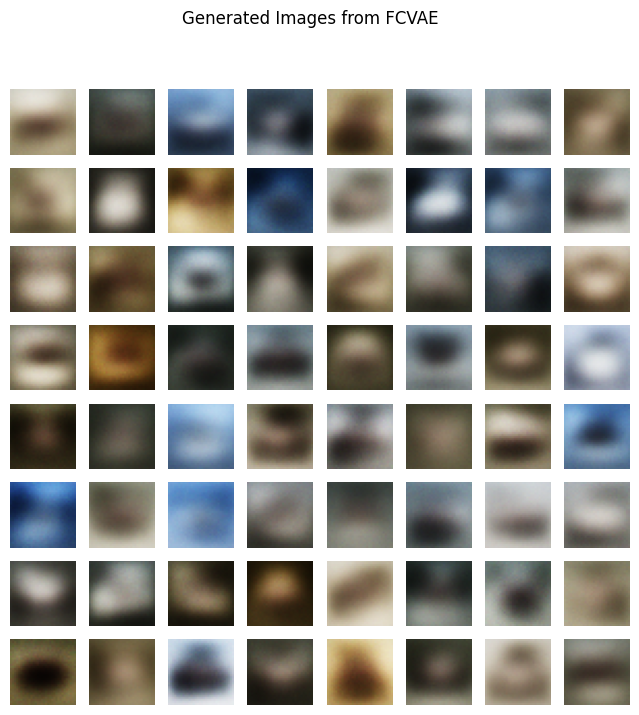

Above we can see that the convulutional layers lead to more information about each image than the fully connected layers. This is because the convolutional layers aim to preserve more positional and patterned information than the fully connected layers. Above, even with only training for a little bit, we can see much more distinct generated images from the VAE with convolutional layers are much more distinct than the blobs in the second VAE.

### Task 2

In [ ]:
import numpy as np

# Function to interpolate between two latent vectors
def interpolate_latent_space(model, img1, img2, num_steps=10):
    model.eval()
    with torch.no_grad():
        # Encode the images to get their latent representations
        mu1, logvar1 = model.encode(img1.unsqueeze(0).to(device))
        mu2, logvar2 = model.encode(img2.unsqueeze(0).to(device))
        z1 = model.reparameterize(mu1, logvar1)
        z2 = model.reparameterize(mu2, logvar2)
        
        # Interpolate between the two latent vectors
        interpolated_z = [z1 * (1 - t) + z2 * t for t in np.linspace(0, 1, num_steps)]
        
        # Decode the interpolated latent vectors to generate images
        interpolated_imgs = [model.decode(z).cpu().squeeze(0) for z in interpolated_z]
        
    return interpolated_imgs

# Select two images from the dataset
img1, _ = train_dataset[0]
img2, _ = train_dataset[1]

# Interpolate between the two images
interpolated_images = interpolate_latent_space(model, img1, img2, num_steps=10)

# Function to visualize the interpolated images
def show_interpolated_images(images, title):
    fig, axes = plt.subplots(1, len(images), figsize=(20, 2))
    fig.suptitle(title)
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].permute(1, 2, 0))
        ax.axis('off')
    plt.show()

# Display the interpolated images
show_interpolated_images(interpolated_images, "Interpolated Images from ConvVAE")

### Task 3

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision.datasets import CelebA
from torchvision.transforms import Compose, Resize, ToTensor

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load CelebA dataset
transform = Compose([
    Resize((64, 64)),
    ToTensor(),
])
celeba_dataset = CelebA(root='./data', split='train', download=True, transform=transform)

# Limit the dataset to the first 51183 images
max_index = 51183
celeba_subset = Subset(celeba_dataset, range(max_index))
celeba_loader = DataLoader(celeba_subset, batch_size=128, shuffle=True)

# Define the convolutional VAE architecture for CelebA
class CelebAVAE(nn.Module):
    def __init__(self, latent_dim):
        super(CelebAVAE, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(256*4*4, latent_dim)
        self.fc_logvar = nn.Linear(256*4*4, latent_dim)
        
        # Decoder
        self.decoder_fc = nn.Linear(latent_dim, 256*4*4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),
        )
    
    def encode(self, x):
        h = self.encoder(x)
        h = h.view(h.size(0), -1)
        return self.fc_mu(h), self.fc_logvar(h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h = self.decoder_fc(z)
        h = h.view(h.size(0), 256, 4, 4)
        return self.decoder(h)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
import torch.nn.functional as F

# Define the loss function for VAE
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Training the VAE
def train_vae(model, dataloader, epochs=100, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()
    for epoch in range(epochs):
        train_loss = 0
        for batch_idx, (data, _) in enumerate(dataloader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        print(f'Epoch {epoch+1}, Loss: {train_loss / len(dataloader.dataset)}')

def show_images(images, title):
    fig, axes = plt.subplots(8, 8, figsize=(8, 8))
    fig.suptitle(title)
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].permute(1, 2, 0))
        ax.axis('off')
    plt.show()

# Initialize the model
latent_dim = 20
celeba_vae = CelebAVAE(latent_dim).to(device)

# Train the VAE on CelebA dataset
train_vae(celeba_vae, celeba_loader, epochs=10, lr=1e-3)

# Sample from different regions of the latent space
celeba_vae.eval()
with torch.no_grad():
    z = torch.randn(64, latent_dim).to(device)
    sample_celeba = celeba_vae.decode(z).cpu()

# Visualize the generated samples
show_images(sample_celeba, "Generated Images from CelebAVAE")

# Experiment with sampling from different regions of the latent space
def sample_and_show(latent_vectors, title):
    celeba_vae.eval()
    with torch.no_grad():
        samples = celeba_vae.decode(latent_vectors).cpu()
    show_images(samples, title)

# Generate latent vectors from different regions
z1 = torch.randn(64, latent_dim).to(device)  # Standard normal distribution
z2 = torch.ones(64, latent_dim).to(device)   # All ones
z3 = torch.zeros(64, latent_dim).to(device)  # All zeros
z4 = torch.linspace(-2, 2, steps=64).unsqueeze(1).repeat(1, latent_dim).to(device)  # Linearly spaced values

# Show generated images for each set of latent vectors
sample_and_show(z1, "Samples from Standard Normal Distribution")
sample_and_show(z2, "Samples from All Ones")
sample_and_show(z3, "Samples from All Zeros")
sample_and_show(z4, "Samples from Linearly Spaced Values")

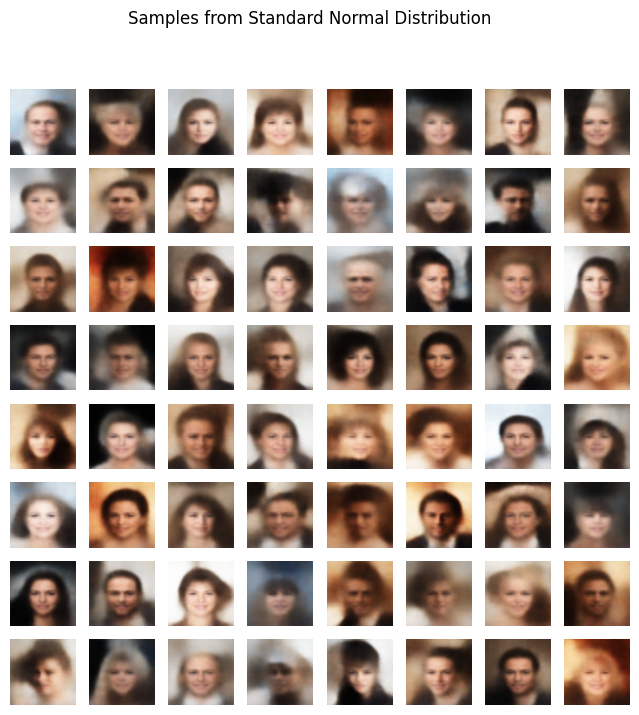

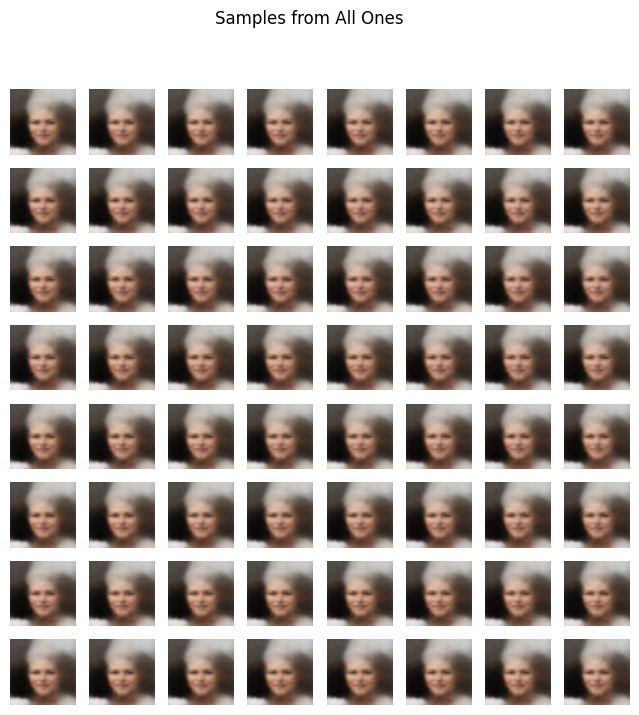

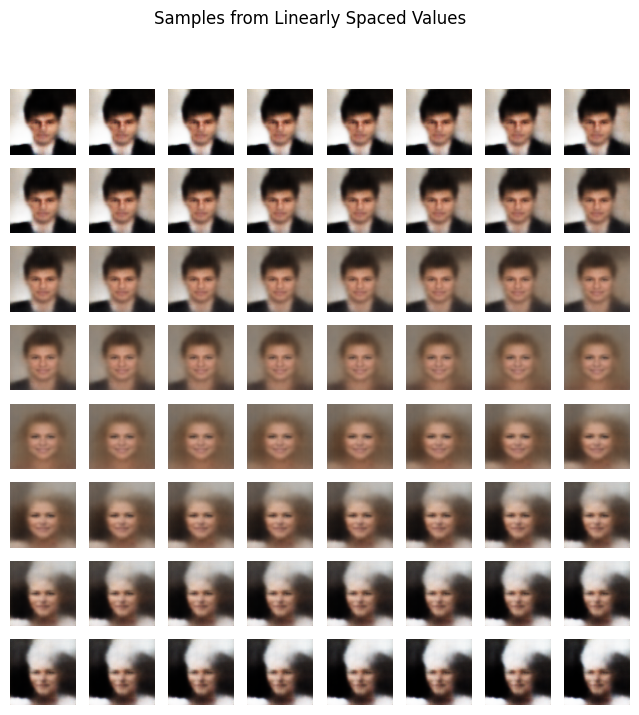